### 2025/04/07 - PS - Streamlined Geron's 1990 CA Housing Price example (O'Reilly text)

#### 2025/04/07 - Import libraries, set up file paths, and write function to download CA housing data

In [4]:
# 2025/04/12 - Import helper notebooks
%run helper_retrieve_files.ipynb

In [1]:
import os
import tarfile
import urllib

In [2]:
data_root_path = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
hous_path = os.path.join("datasets", "housing") #os.path.join ensures 2 parts of a path are combined with appropriate path separator ("/" unix, "\" windows)
hous_url = data_root_path + "datasets/housing/housing.tgz" #Tar file with data gzip compressed.

In [6]:
fetch_and_extract_tgz_file(hous_url, hous_path, "housing.tgz")

/var/folders/2k/hw6g3gc14b15dksr2b6d88q40000gn/T/ipykernel_30394/3960331498.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tgz_file.extractall(path=data_save_path) #Extract files from tar file and save in same directory.


#### 2025/04/07 - Import housing CSV data

In [7]:
import pandas as pd
pd_housing = load_csv_file_from_path(hous_path, "housing.csv")
pd_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
#2025/04/07 - Get a feel for data size (# rows = # districts) and column data type.
#2025/04/07 - total_bedrooms column has some null/missing values.
pd_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
#2025/04/07 - ocean_proximity appears categorical - what categories exist and what's their frequency?
pd_housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [10]:
#2025/04/07 - For numerical variables, let's get a feel for their distributions. Note missing valuees in bedroom variable - handle later with replacement.
pd_housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


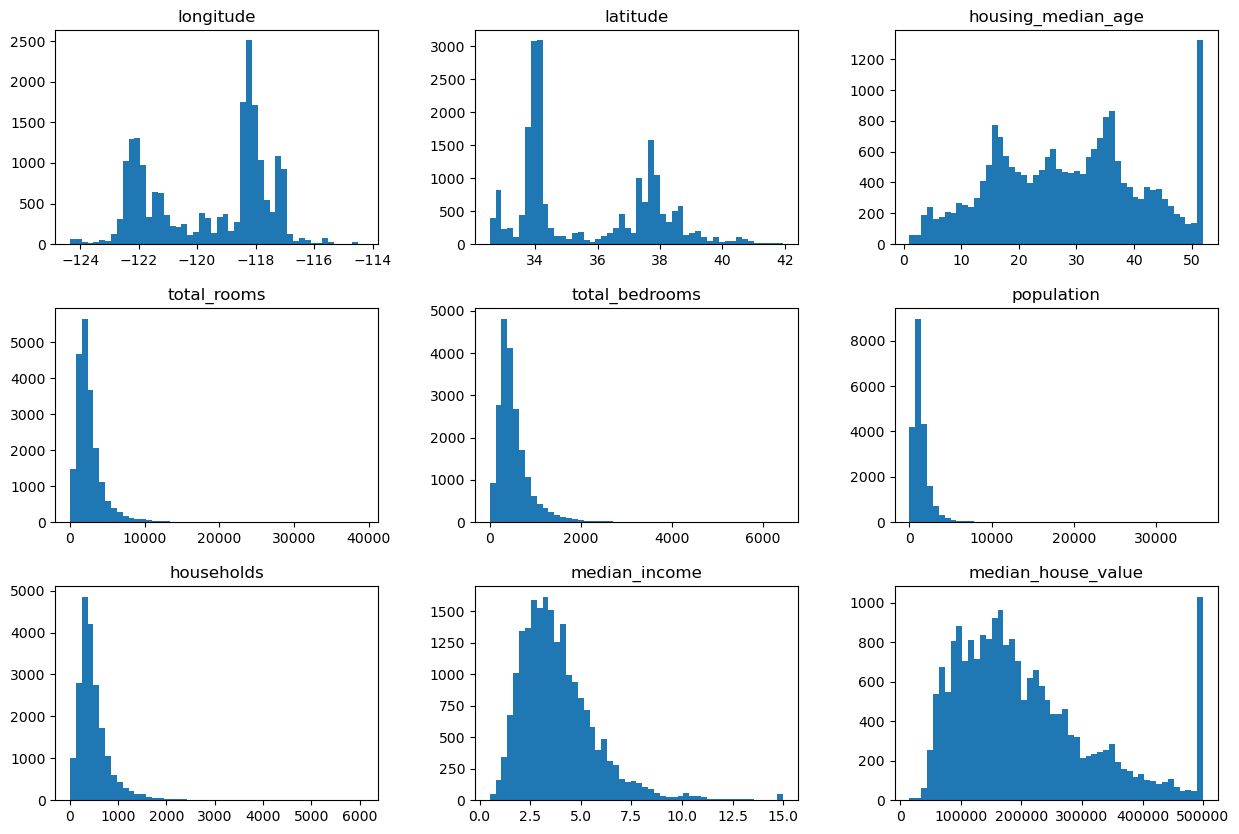

In [11]:
#2025/04/07 - Can also get a feel for the distribution of each numerical variable with a histogram
import matplotlib.pyplot as plt
pd_housing.hist(bins=50, figsize=(15,10), grid=False)
plt.show()

#### 2025/04/07 - Points to note about the data as it currently stands:
1. Median income is approximately in thousands of USD. It is also capped below at 0.5 (actually 0.4999) and above at 15 (actually 15.0001).
2. Median age is capped above - seems just above 50. Median house value is capped above at $500,000 - could be an issue depending on team's needs as this is what we're predicting.
3. Attributes have very different scales - may benefit from feature scaling.
4. Many features are right skewed, with heavy tails above their median. Can consider transforming then, e.g. exponential.

#### 2025/04/07 - Before working more with data, set aside test data to reduce data-snooping bias (i.e. looking at test data to help decide aspects of ML modeling)

In [12]:
#2024/04/07 - Can use scikit-learn's split function with a seed for batch work with unchanging data
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(pd_housing, test_size = 0.2, random_state = 42) #42 - Answer to the Ultimate Question of Life, the Universe, and Everything.
print("train set size:", len(train_set))
print("test set size:", len(test_set))

train set size: 16512
test set size: 4128


#### 2025/04/09 - Median income is expected to be really important predictor of median housing price. It's also fairly spread. Want to ensure incomes across its spectrum are enough to be representative of this spread while minimizing bias (enough incomes in each range). Bucket income by range and plot hist.

Text(0.5, 1.0, 'Count 1990 CA census median income block groups')

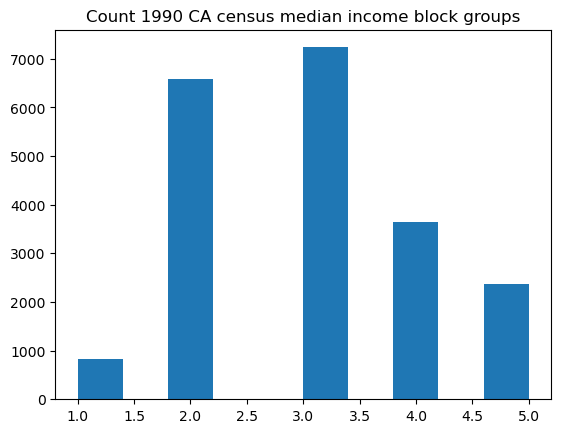

In [13]:
import numpy as np

pd_housing["income_cat"] = pd.cut(pd_housing["median_income"],
                                  bins = [0, 1.5, 3, 4.5, 6, np.inf],
                                  labels = [1, 2, 3, 4, 5])

pd_housing["income_cat"].hist(grid=False)
plt.title("Count 1990 CA census median income block groups")

#### 2025/04/09 - Want to ensure both training and test data contain "representative" split of median income - cover full range with enough points in each - perform stratified sampling.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42) # Get 1 train and test split, with 20% in test data.
for train_index, test_index in split.split(pd_housing, pd_housing["income_cat"]):
    strat_train_set = pd_housing.loc[train_index]
    strat_test_set = pd_housing.loc[test_index]

#### 2025/04/09 - To ensure sampling of train and test is done as we expect, check fraction of train and test data in each income category grouping. Respective fractions align with full dataset. Also - note percentage difference in test sets from full data is larger for the randomized test set without adhering to income stratification.

In [15]:
full_data_inc_split = (pd_housing["income_cat"].value_counts()/len(pd_housing)).sort_index()
strat_test_data_inc_split = (strat_test_set["income_cat"].value_counts()/len(strat_test_set)).sort_index()
strat_test_data_inc_split_perc = 100*(full_data_inc_split - strat_test_data_inc_split)/full_data_inc_split

test_set["income_cat"] = pd.cut(test_set["median_income"],
                                bins = [0, 1.5, 3, 4.5, 6, np.inf],
                                labels = [1, 2, 3, 4, 5])

rand_test_data_inc_split = (test_set["income_cat"].value_counts()/len(test_set)).sort_index()
rand_test_data_inc_split_perc = 100*(full_data_inc_split - rand_test_data_inc_split)/full_data_inc_split

In [16]:
print("Full - Strat Test Data:", strat_test_data_inc_split_perc)
print("Full - Rand Test Data:", rand_test_data_inc_split_perc)

pd_test_set_diff = pd.DataFrame({'Overall': full_data_inc_split, 'Rand': rand_test_data_inc_split, 'Strat': strat_test_data_inc_split,
                              'Rand_Perc_Err': rand_test_data_inc_split_perc, 'Strat_Perc_Err': strat_test_data_inc_split_perc})

display(pd_test_set_diff)

Full - Strat Test Data: income_cat
1   -0.364964
2    0.015195
3    0.013820
4   -0.027480
5    0.084674
Name: count, dtype: float64
Full - Rand Test Data: income_cat
1   -0.973236
2   -1.732260
3   -2.266446
4    5.056334
5    4.318374
Name: count, dtype: float64


,Overall,Rand,Strat,Rand_Perc_Err,Strat_Perc_Err
income_cat,,,,,
1,0.039826,0.040213,0.039971,-0.973236,-0.364964
2,0.318847,0.324370,0.318798,-1.732260,0.015195
3,0.350581,0.358527,0.350533,-2.266446,0.013820
4,0.176308,0.167393,0.176357,5.056334,-0.027480
5,0.114438,0.109496,0.114341,4.318374,0.084674


#### 2025/04/09 - Remove income_cat column from train and test data, as we're not going to use it in our ML modeling

In [17]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

print(strat_test_set.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


## 2025/04/09 - Explore and Visualize Data to Gain Insights

### 2025/04/09 - Visualize Geographical Housing Price Data

#### 2025/04/09 - Create copy of training data to work with, without worry of affecting our training data

In [18]:
pd_housing_explore = strat_train_set.copy()

#### 2025/04/09 - With lat and long data - can scatter it using lat and long values to create zoomed-in figure without satellite/geo feature background

Text(0.5, 1.0, '1990 CA Census Blocks in Housing Price Data')

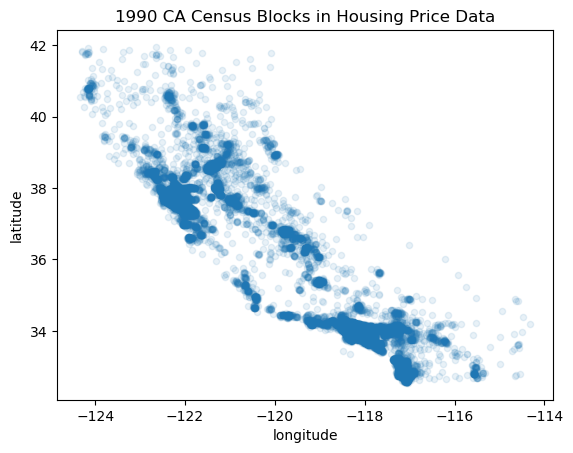

In [19]:
pd_housing_explore.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.1) #Add transparency to see where census blocks are clustered (higher pop density areas)
plt.title("1990 CA Census Blocks in Housing Price Data")

Text(0.5, 1.0, '1990 CA Census Blocks in Housing Price Data')

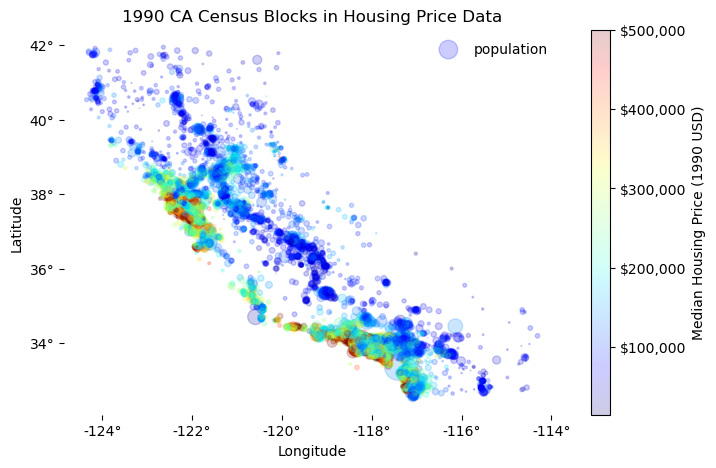

In [20]:
#2025/04/09 - Add price visualization by coloring each block based on median housing price, and giving it a larger size based on district population
#             Use jet coloring (blue = low, red = high), and add a colorbar for viewer to know scheme.

import matplotlib.ticker as ticker #Library needed to modify tick labels directly

fig = pd_housing_explore.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.2,
                        s=pd_housing_explore["population"]/100, label = "population", figsize=(8,5),
                        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=False)


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(frameon=False) #Remove legend frame

ax = plt.gca() #Get current axis to remove plot border and modify tick labels with degree symbol

# Remove figure spines (borders)
spine_names = ax.spines
for spine_name in spine_names:
    ax.spines[spine_name].set_visible(False)

# Function adding degree symbol to tick values
def format_degrees(value, pos):
    return f'{value:.0f}°'

# Apply degree formatter to x and y axes
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_degrees))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_degrees))

# Add colorbar, set label, and modify tick value formatting to include dollars and commas 
comma_fmt = ticker.FuncFormatter(lambda x, p: f'${format(int(x), ',')}')
cbar = plt.colorbar(ax.collections[0], ax=ax, format=comma_fmt)
cbar.set_label('Median Housing Price (1990 USD)')

# Add descriptive title
plt.title("1990 CA Census Blocks in Housing Price Data")

### 2025/04/09 - Explore correlation of potential features with variable of interest - median house value

In [21]:
#2025/04/09 - Store matrix of all simple linear correlations - look at median house value correlations.
corr_matrix = pd_housing_explore.drop('ocean_proximity', axis=1).corr()
print(corr_matrix['median_house_value'].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


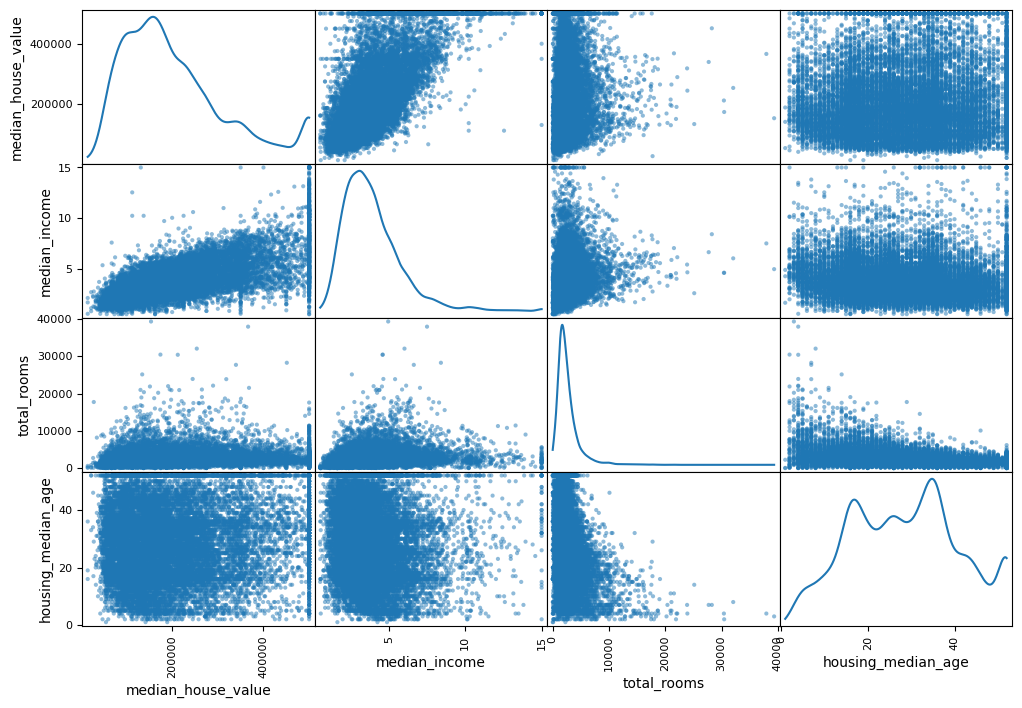

In [22]:
#2025/04/09 - Explore correlations visually with pandas scatter_matrix() command on just a few numerical attributes
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(pd_housing_explore[attributes], figsize=(12,8), diagonal='kde');

#### 2025/04/09 - Since highest correlation comes from median income, we can look exclusively at that correlation. Note lines of data (capping/bucketing) at 500k, 450k, 350k, and maybe 280k. Removing before fitting can help model not adopt these quirks in its predictions.

<Axes: xlabel='median_income', ylabel='median_house_value'>

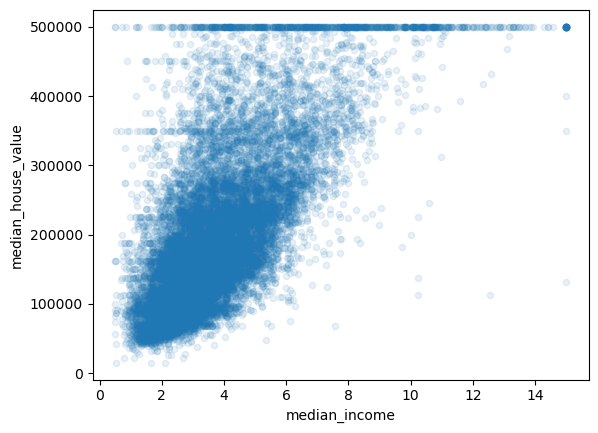

In [23]:
pd_housing_explore.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

#### 2025/04/09 - Some notable conclusions from preliminary data investigation - for simplicity only handling #3.
1. We have some bucketed variables, e.g. median income. Don't want ML model to adopt same behavior.
2. We have some right-skewed variables. May benefit from applying logarithm.
3. Some variables in current form aren't really useful, e.g. # rooms, # bedrooms, and population, because they don't get as directly at individual average household characteristics or population density/housing scarcity. We could get: 
> 1. average # rooms/house (are houses on average larger or smaller), 
> 2. average # bedrooms/rooms (apriori unsure - higher values are higher density housing, and may be cheaper housing - negative corr), 
> 3. and # population/household (gives a sense of housing scarcity/density - positive corr).

### 2025/04/09 - Create features listed in #3 above which feel more directly affecting median housing price and check correlation

In [24]:
pd_housing_explore["rooms_per_house"] = pd_housing_explore['total_rooms']/pd_housing_explore['households']
pd_housing_explore["bedrooms_per_room"] = pd_housing_explore['total_bedrooms']/pd_housing_explore['total_rooms']
pd_housing_explore["pop_per_house"] = pd_housing_explore['population']/pd_housing_explore['households']

In [25]:
corr_matrix = pd_housing_explore.drop('ocean_proximity', axis=1).corr()
print(corr_matrix['median_house_value'].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.687151
rooms_per_house       0.146255
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
pop_per_house        -0.021991
population           -0.026882
longitude            -0.047466
latitude             -0.142673
bedrooms_per_room    -0.259952
Name: median_house_value, dtype: float64


#### 2025/04/09 - Interesting - rooms per house (size of average house in district) has higher correlation than total rooms, and more bedrooms per room (higher density housing) has considerable negative correlation which wasn't obvious from original correlation investigation. Both seem initially valuable features to include in our modeling.

## 2025/04/09 - Prepare Data for ML Process

#### 2025/04/09 - Will eventually create functions to more easily reproduce data cleaning and/or transformations of data for feeding into ML algorithms.

### 2025/04/09 - Data Cleaning

#### 2025/04/09 - Revert to training data before adding modified attributes with a fresh copy of the training data, and create a dataset of only the features

In [26]:
pd_housing_features = strat_train_set.drop("median_house_value", axis=1) #drop creates a copy of the data
pd_housing_prices = strat_train_set["median_house_value"].copy()

#### 2025/04/09 - Most ML algos don't work with missing features. Create functions to handle this.

#### 2025/04/09 - total_bedrooms has missing values - can either drop N/A districts, remove feature for all districts, or fill in/interpolate N/A values. If we drop N/A districts/rows - we would have to drop the same rows in the prices (Y) dataset. Also if we fill N/A values, same values/method must be applied to test data.

#### 2025/04/09 - Use sklearn's SimpleImputer transformer to replace N/A values with the median value across all districts (in reality I would do something more complex, like median from X nearest neighbors)

In [27]:
from sklearn.impute import SimpleImputer

med_imputer = SimpleImputer(strategy="median") #Only applies to numerical data, so ensure categorical features removed before applying

In [28]:
pd_housing_features_num = pd_housing_features.drop("ocean_proximity", axis=1)
print(list(set(pd_housing_features.columns) - set(pd_housing_features_num.columns))) #Verify ocean_proximity not in numerical dataframe.

['ocean_proximity']


In [29]:
#2025/04/09 - Fit imputer to train data storing fill values, and transform train data to fill N/As with respective fill values.
med_imputer.fit(pd_housing_features_num)
print(med_imputer.statistics_)

X = med_imputer.transform(pd_housing_features_num)
print(type(X))

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
<class 'numpy.ndarray'>


In [30]:
#2025/04/09 - Applying imputer transform method to dataframe results in a Numpy array. Convert back to Pandas dataframe.
pd_housing_features_num_tr = pd.DataFrame(X, columns=pd_housing_features_num.columns, index = pd_housing_features_num.index)
#2025/04/09 - Ensure total bedrooms now has same count as other features (lower overall count due train data - not full data).
pd_housing_features_num_tr.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,533.939438,1419.687379,497.011810,3.875884
std,2.001828,2.137963,12.574819,2138.417080,410.806260,1115.663036,375.696156,1.904931
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,296.000000,784.000000,279.000000,2.566950
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550
75%,-118.010000,37.720000,37.000000,3141.000000,641.000000,1719.000000,602.000000,4.745325
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


### 2025/04/09 - Handling Text & Categorical Features

In [31]:
def identify_categorical_columns(df):
    """
    Identifies and returns list of categorical column names in Pandas DataFrame.
    Args: df (pd.DataFrame): The input DataFrame.
    Returns: list: A list of column names with object or category data types.
    """
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    return categorical_cols

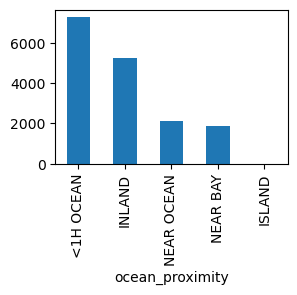

In [32]:
#2025/04/09 - Check out categorical feature values (already done above)
categorical_columns = identify_categorical_columns(pd_housing_features)

for cat_col in categorical_columns:
    pd_housing_features[cat_col].value_counts().plot.bar(figsize=(3,2))
    

#### 2025/04/13 - Most ML algos prefer numerical categories - specifically one-hot-encoded values (dummy values).

In [33]:
#2025/04/09 - Create dataframe of categorical columns - then convert to integers (encode them)
pd_housing_features_cat = pd_housing_features[categorical_columns]

#2025/04/09 - OHE results in a SciPy sparse matrix. Can get a numpy (dense) array using the toarray() method (scipy_matrix.toarray())
from sklearn.preprocessing import OneHotEncoder
ohe_encoder = OneHotEncoder()
pd_housing_cat_ohe = ohe_encoder.fit_transform(pd_housing_features_cat)
pd_housing_cat_ohe

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [34]:
print(ohe_encoder.categories_)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


### 2025/04/09 - Creating Modified Features using Custom Transformers

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, pop_ix, households_ix = 3, 4, 5, 6

# Adding TrasnformerMixIn allows custom transformer to inherit fit_transform() method. 
# Adding BaseEstimator allows inheriting get_params() and set_params() methods, useful for automatic hyperparameter tuning.
class ModifiedFeaturesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): #no *args or **kargs - default add bedrooms per room feature
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # This transformer doesn't require looking to the data for any values - nothing more to do.
    def transform(self, X):
        #Always add rooms and pop per household.
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        pop_per_household = X[:, pop_ix] / X[:, households_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, pop_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, pop_per_household]

In [36]:
print(type(pd_housing_features.values))

<class 'numpy.ndarray'>


In [37]:
feature_adder = ModifiedFeaturesAdder(add_bedrooms_per_room=False)
house_extra_feats = feature_adder.transform(pd_housing_features.values) #Has to read in a numpy array of data, not a Pandas DataFrame

In [38]:
print(house_extra_feats[:5])
display(pd_housing_features[:5])

[[-121.46 38.52 29.0 3873.0 797.0 2237.0 706.0 2.1736 'INLAND'
  5.485835694050992 3.168555240793201]
 [-117.23 33.09 7.0 5320.0 855.0 2015.0 768.0 6.3373 'NEAR OCEAN'
  6.927083333333333 2.6236979166666665]
 [-119.04 35.37 44.0 1618.0 310.0 667.0 300.0 2.875 'INLAND'
  5.3933333333333335 2.223333333333333]
 [-117.13 32.75 24.0 1877.0 519.0 898.0 483.0 2.2264 'NEAR OCEAN'
  3.886128364389234 1.8592132505175984]
 [-118.7 34.28 27.0 3536.0 646.0 1837.0 580.0 4.4964 '<1H OCEAN'
  6.096551724137931 3.1672413793103447]]


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


### 2025/04/09 - Feature Scaling (ML algos may perform worse when numerical features have different scales) with Transformation Pipelines

#### 2025/04/09 - Two common methods, min-max scaling (e.g. normalize values on 0-1 scale - neural networks), and standardization (all values in units of standard deviations - less affected by outliers).

#### 2025/04/09 - Can combine several transformation steps into a single pipeline, which makes clear the ordering of the transformation steps

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [40]:
pipeline_num = Pipeline([ ('imputer', SimpleImputer(strategy="median")),
                          ('feature_adder', ModifiedFeaturesAdder()),
                          ('std_scaler', StandardScaler())
                          ])

In [41]:
# housing_num_tr = pipeline_num.fit_transform(pd_housing_features_num)
# display(housing_num_tr[:1])

#### 2025/04/09 - Add categorical transformation to numerical transformation with ColumnTransformer

In [42]:
from sklearn.compose import ColumnTransformer

lst_num_features = list(pd_housing_features_num)
lst_cat_features = categorical_columns

pipeline_full = ColumnTransformer([ ('num', pipeline_num, lst_num_features),
                                    ('cat', OneHotEncoder(), lst_cat_features)
                                 ])

housing_prepared = pipeline_full.fit_transform(pd_housing_features)

display(housing_prepared[:2])

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
        -0.12112176,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
        -0.81086696,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ]])

### 2025/04/10 - Select and Train Model (Y = 1990 Median Housing Price in CA census districts) and base evaluation

#### 2025/04/10 - Start with linear regression

In [43]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, pd_housing_prices) #LinearRegression casts y data type to X data type (pandas data converted to numpy array)

LinearRegression()

#### 2025/04/10 - Lets see some predictions and visually inspect how close they are to actual values

In [44]:
some_data_prepared = housing_prepared[:5]
some_ys = pd_housing_prices[:5]
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Ys:", list(some_ys))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Ys: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


#### 2025/04/10 - ML modeling is operational, however errors appear to be sizable (40-50% on the 3rd obs). Check model error on training data metrics (e.g. RMSE).

In [45]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

lin_housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(pd_housing_prices, lin_housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Train Lin Reg RMSE:", lin_rmse)

lin_r2 = r2_score(pd_housing_prices, lin_housing_predictions)
print("Train Lin Reg R2:", lin_r2) #2025/04/10 - Linear Regression has around 65% better accuracy (reduced error) than simply using the mean as a prediction (uninformed predictions).

Train Lin Reg RMSE: 68627.87390018745
Train Lin Reg R2: 0.6481553634454353


#### 2025/04/10 - In optimizing modeling performance, can consider different model, different features into same modeling, or reduce constraints/regularization. For now, try different model - decision tree.

In [46]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, pd_housing_prices)

DecisionTreeRegressor()

In [47]:
#2025/04/10 - Evaluate modeling again based on RMSE and R2.
tree_housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(pd_housing_prices, tree_housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Train Dec Tree RMSE:", tree_rmse)

tree_r2 = r2_score(pd_housing_prices, tree_housing_predictions)
print("Train Dec Tree R2:", tree_r2) #2025/04/10 - Zero error - complete fit? Sign of overfitting. Plus not evaluating model on hold-out set.

Train Dec Tree RMSE: 0.0
Train Dec Tree R2: 1.0


### 2025/04/10 - Improve model evaluation using Cross-Validation (e.g. K-fold validation) - using 5 folds to reduce runtime

In [48]:
from sklearn.model_selection import cross_val_score

#2025/04/10 - Can eventually use cross_validate, as it allows for computing multiple scoring metrics, e.g. mse and r2 at the same time (should be faster).
#sklearn cross_val_score expects utility fn (higher is better), so scoring is opposite of MSE
tree_nmse_scores = cross_val_score(tree_reg, housing_prepared, pd_housing_prices, scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-tree_nmse_scores)

tree_r2_scores = cross_val_score(tree_reg, housing_prepared, pd_housing_prices, scoring="r2", cv=5)

In [49]:
def display_model_scores(score_type, scores):
    print(f"{score_type} Scores:", scores)
    print(f"{score_type} Mean:", scores.mean())
    print(f"{score_type} Standard Deviation:", scores.std())

In [50]:
#2025/04/10 - Decision-tree modeling on average over multiple hold-out sets performs worse in accuracy than linear regression.
display_model_scores('rmse', tree_rmse_scores)
display_model_scores('r2', tree_r2_scores)

rmse Scores: [69461.76698385 71377.61138779 69305.78139177 73701.00664373
 71393.40695267]
rmse Mean: 71047.91467196094
rmse Standard Deviation: 1601.1155302192456
r2 Scores: [0.64067466 0.62044517 0.64945857 0.59924805 0.62358041]
r2 Mean: 0.62668136923997
r2 Standard Deviation: 0.017410951996696202


In [51]:
#2025/04/10 - Compute same scores using linear regression for proper comparison (comparing performance on test data instead of training data)
lin_nmse_scores = cross_val_score(lin_reg, housing_prepared, pd_housing_prices, scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_nmse_scores)

lin_r2_scores = cross_val_score(lin_reg, housing_prepared, pd_housing_prices, scoring="r2", cv=5)

display_model_scores('rmse', lin_rmse_scores)
display_model_scores('r2', lin_r2_scores)

rmse Scores: [68076.63768302 67881.16711321 69712.97514343 71266.9225777
 68390.25096271]
rmse Mean: 69065.59069601324
rmse Standard Deviation: 1272.9445955637552
r2 Scores: [0.65072257 0.65162332 0.6381072  0.62158966 0.6553829 ]
r2 Mean: 0.64348513088622
r2 Standard Deviation: 0.012397594061170903


In [52]:
#2025/04/10 - Try an ensemble decision tree method (many decision trees on feature subsets and averaging predictions) - Random Forest modeling
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, pd_housing_prices)

forest_housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(pd_housing_prices, forest_housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Dec Tree RMSE:", forest_rmse)

forest_r2 = r2_score(pd_housing_prices, forest_housing_predictions)
print("Dec Tree R2:", forest_r2)

forest_nmse_scores = cross_val_score(forest_reg, housing_prepared, pd_housing_prices, scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_nmse_scores)

forest_r2_scores = cross_val_score(forest_reg, housing_prepared, pd_housing_prices, scoring="r2", cv=5)

display_model_scores('rmse', forest_rmse_scores)
display_model_scores('r2', forest_r2_scores)

Dec Tree RMSE: 18712.25393125954
Dec Tree R2: 0.9738421496625815
rmse Scores: [50422.74649341 50144.54525382 49938.83986785 51888.00994184
 51732.24756467]
rmse Mean: 50825.27782431916
rmse Standard Deviation: 820.145623543614
r2 Scores: [0.80911821 0.81300654 0.81580976 0.79991901 0.80319678]
r2 Mean: 0.8082100590413974
r2 Standard Deviation: 0.005923865282628854


In [ ]:
#2025/04/13 - Try out Support Vector Machine regression modeling with either and rbf kernels, with various C and gamma hyperparmeters.
from sklearn.svm import SVR

svr_lin = SVR(kernel='linear') # SVM regressor with linear kernel
svr_rbf = SVR(kernel='rbf') # SVM regressor with RBF (radial basis function) kernel

svr_param_grid = [{'gamma': [0.0001, 0.01, 1, 100], 'C': [0.01, 1, 100, 10000]}]

svr_lin_grid_r2 = GridSearchCV(svr_lin, svr_param_grid, cv=3)
svr_lin_grid_r2.fit(housing_prepared, pd_housing_prices)

svr_rbf_grid_r2 = GridSearchCV(svr_rbf, svr_param_grid, cv=3)
svr_rbf_grid_r2.fit(housing_prepared, pd_housing_prices)

print(
    "The best SVR Lin parameters are %s with a score of %0.2f"
    % (svr_lin_grid_r2.best_params_, svr_lin_grid_r2.best_score_)    
)

print(
    "The best SVR RBF parameters are %s with a score of %0.2f"
    % (svr_rbf_grid_r2.best_params_, svr_rbf_grid_r2.best_score_)
)

The best SVR Lin parameters are {'C': 100, 'gamma': 0.0001} with a score of 0.61
The best SVR RBF parameters are {'C': 10000, 'gamma': 0.01} with a score of 0.65


### 2025/04/10 - Model Fine Tuning (have a shortlist of promising models and experiment with hyperparameter tuning for best model fit)

#### 2025/04/11 - Can perform more automatic hyperparameter tuning using sklearn's GridSearchCV (cross-validate on several hyperparameter options)

In [53]:
from sklearn.model_selection import GridSearchCV

#2025/04/11 - Let's look at the RandomForestRessor across several hyperparameter options

param_grid = [
              {'n_estimators': [3,10,30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]}
            ]

forest_reg = RandomForestRegressor()

#2025/04/11 - Grid search is told which modeling method, hyperparameter options, # of folds in cross validation, scoring method, and whether to return training set model scores instead of just test-set scores. 
rf_grid_search_nmse = GridSearchCV(forest_reg, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True) #did 3 to try to reduce runtime
rf_grid_search_r2 = GridSearchCV(forest_reg, param_grid, cv=3, scoring='r2', return_train_score=True) #did 3 to try to reduce runtime

rf_grid_search_nmse.fit(housing_prepared, pd_housing_prices)
rf_grid_search_r2.fit(housing_prepared, pd_housing_prices)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='r2')

In [54]:
#2025/04/11 - Can get best parameters and best estimator directly.
print(rf_grid_search_nmse.best_estimator_)
print(rf_grid_search_r2.best_score_)

RandomForestRegressor(max_features=6, n_estimators=30)
0.809334131298546


In [55]:
#2025/04/11 - Can also explore eval scores of each fit model directly
cv_res_r2 = rf_grid_search_r2.cv_results_

for mean_score, params in zip(cv_res_r2["mean_test_score"], cv_res_r2["params"]):
    print(mean_score, params)

0.6838727682867689 {'max_features': 2, 'n_estimators': 3}
0.7615532695393963 {'max_features': 2, 'n_estimators': 10}
0.7902397536905684 {'max_features': 2, 'n_estimators': 30}
0.7116164303996776 {'max_features': 4, 'n_estimators': 3}
0.7857779340428789 {'max_features': 4, 'n_estimators': 10}
0.8007440546904214 {'max_features': 4, 'n_estimators': 30}
0.7398817213970617 {'max_features': 6, 'n_estimators': 3}
0.7945588759496777 {'max_features': 6, 'n_estimators': 10}
0.809334131298546 {'max_features': 6, 'n_estimators': 30}
0.7379938488458081 {'max_features': 8, 'n_estimators': 3}
0.7903214340036685 {'max_features': 8, 'n_estimators': 10}
0.8070439645058243 {'max_features': 8, 'n_estimators': 30}
0.7087181867658049 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.7760415061883869 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.7298932551813374 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.7909380384404163 {'bootstrap': False, 'max_features': 3, 'n_

### 2025/04/11 - Analyze Best Model and Errors - E.g. which features were most important and which less so

In [56]:
#2025/04/11 - Get feature importances with corresponding feature names.
rf_feature_importances = rf_grid_search_r2.best_estimator_.feature_importances_ #Is lacking feature names.

lst_extra_features = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"] #Make names for added features.
cat_encoder = pipeline_full.named_transformers_["cat"] #Get labels for each ocean proximity category (first get transformer, and from fit transformer get categories)
lst_cat_one_hot_features = list(cat_encoder.categories_[0])
lst_all_features = lst_num_features + lst_extra_features + lst_cat_one_hot_features

sorted(zip(rf_feature_importances, lst_all_features), reverse=True)

[(0.2931315898632755, 'median_income'),
 (0.16221749994541898, 'INLAND'),
 (0.10257634068131347, 'pop_per_hhold'),
 (0.08190835309840241, 'longitude'),
 (0.0779222959959848, 'rooms_per_hhold'),
 (0.07628402134550318, 'bedrooms_per_room'),
 (0.0752425734424265, 'latitude'),
 (0.041192705399625315, 'housing_median_age'),
 (0.01769987077277859, 'population'),
 (0.017615917872864328, 'total_rooms'),
 (0.017068872760262217, 'total_bedrooms'),
 (0.016315079853707396, 'households'),
 (0.011767599652727046, '<1H OCEAN'),
 (0.004738728940282228, 'NEAR OCEAN'),
 (0.004293368476759018, 'NEAR BAY'),
 (2.518189866897253e-05, 'ISLAND')]

### 2025/04/11 - Evaluate chosen model on test set

In [57]:
final_model = rf_grid_search_r2.best_estimator_

#2025/04/11 - Create copies of test data (features and outcome)
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = pipeline_full.transform(X_test) #Get test set features in ML model format

final_predictions = final_model.predict(X_test_prepared) #Make predictions using fit model

#Calculate evaluation scores
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_r2 = r2_score(y_test, final_predictions)

print("Final RMSE:", final_rmse)
print("Final R2:", final_r2)

Final RMSE: 47826.639167967536
Final R2: 0.8244946626116219


#### 2025/04/11 - How well did our final model perform in percentage accuracy (prior method was off by 20% on average)

In [58]:
from sklearn.metrics import mean_absolute_percentage_error

print(mean_absolute_percentage_error(y_test, final_predictions)) #Our modeling is slightly more accurate than 20% on average.

0.1841209282889447


### 2025/04/12 - There's still considerable work after this point to "finish" such a project, e.g.
1. Create visualizations/summary to present results to supervisors/managers.
2. Create production pipeline (QA, PROD versions of code, cluster to run on, CRON job/Airflow job).
3. Add unit tests to ensure internal code consistency (minimize adding extra runtime while still maintaining internal confidence).
4. Add results monitoring, e.g. dashboard, checks on model performance/degradation with alerts sent when model found to have degraded "enough."

### 2025/04/13 - Some remaining data-cleaning/prep work which could further improve results
1. Handle bucketing of data, e.g. drop bucketed values (median house income), or find some reasonable interpolation/replacement process
2. Log right-skewed features before standardizing to reduce potential "outlier" values on standardization process. Also helps ensure more normally distributed errors in models which assume errors to be normally distributed (e.g. linear regression).